## Summary

- write instead of the TS diagram, let's create an overall timeseries of the gateway transport
- this will be as in the proposal and from the notebooks verify_gates_12_15 and wmt_spellout_bigaste
- given that the transport through the gates at one timestep is advection in 3D - flattened and binned - binwidthT or binwidthS
- we can plot the overall contribution to heat/salt over time from the various terms

## goals here:
- GOAL: did the heat contribution from the gates change over time/did the role of the heat contribution change?

In [1]:
# import the packages and functions

# auto-reload edited moduleås
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
# gates and series
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

# the BSO reading is also wrong
choose_UV_bso[20] = "H"
x_bso[x_bso == 161] = 162

# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

In [3]:
# we should redefine gates I think
# start with NaNs (float array so NaN is valid)
gates = np.full((ny, nx), np.nan, dtype=float)

def _paint(x_idx, y_idx, value):
    x = np.asarray(x_idx, dtype=int)
    y = np.asarray(y_idx, dtype=int)
    # keep only points inside the domain
    m = (y >= 0) & (y < ny) & (x >= 0) & (x < nx)
    gates[y[m], x[m]] = value

# 1,2,3,4 for BSO, SFJ, FJNZ, NZRU
_paint(x_bso,  y_bso,  1)
_paint(x_sfj,  y_sfj,  2)
_paint(x_fjnz, y_fjnz, 3)
_paint(x_nzru, y_nzru, 4)

In [4]:
# this is the indices we READ FROM

# plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0],cmap="Greys",vmin=-2,vmax=4)
# plt.pcolormesh(get_aste_tracer(gates,nfx,nfy)[0])
# plt.ylim(400,550)
# plt.xlim(400,540)

In [5]:
y_bsoh,x_bsoh = np.where(gates==1)[0][:21],np.where(gates==1)[1][:21]
y_bsov,x_bsov = np.where(gates==1)[0][21:],np.where(gates==1)[1][21:]
y_fjnzv,x_fjnzv = np.where(gates==3)[0][:21],np.where(gates==3)[1][:21]
y_nzruv,x_nzruv = np.where(gates==4)[0][:21],np.where(gates==4)[1][:21]

In [6]:
# do spfj -- this is a weird one
a,b = np.where(gates ==2)[0],np.where(gates ==2)[1]

testmsk = np.zeros((ny,nx))
testmsk[a,b] = 1
testmsk[a[:3],b[:3]] = 2
testmsk[a[3],b[3]] = 3  # corner
testmsk[a[7:11],b[7:11]] = 2
testmsk[a[11],b[11]] = 3   # corner
testmsk[a[14:20],b[14:20]] = 2
testmsk[a[20],b[20]] = 3   # corner
testmsk[a[24:28],b[24:28]] = 2
testmsk[a[28],b[28]] = 3   # corner
testmsk[a[33:37],b[33:37]] = 2
testmsk[a[37],b[37]] = 3   # corner
testmsk[a[44:],b[44:]] = 2

testmsk[testmsk==0] = np.nan
# plt.pcolormesh(testmsk)
# plt.xlim(50,100)
# plt.ylim(450,600)

In [7]:
y_spfjh,x_spfjh = np.where(testmsk == 1)[0],np.where(testmsk == 1)[1]
y_spfjv,x_spfjv = np.where(testmsk == 2)[0],np.where(testmsk == 2)[1]
y_spfjb,x_spfjb = np.where(testmsk == 3)[0],np.where(testmsk == 3)[1]

In [12]:
forward_path = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
dirdiags = forward_path + "diags/BUDG/"
dirState = forward_path + "diags/STATE/"
dirLayers = layers_path + "diags/LAYERS/"

In [41]:
# load the TS bins
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

# pause here, I think it would be good to create a program to create layers based on input time step

In [81]:
from create_layers import create_layers

In [82]:
# define tstep 
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(3,4,1)
# times['2008'] = np.array([1])
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr

{'2007': array([3])}


array(['0000271440'], dtype='<U32')

In [83]:
G_T_offline_new,ADV_Tnew,G_S_offline_new,ADV_Snew = create_layers(tsstr,mygrid,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy)

In [84]:
# G_T_offline_new

Text(0.5, 1.0, 'ADVh contrib to Salt')

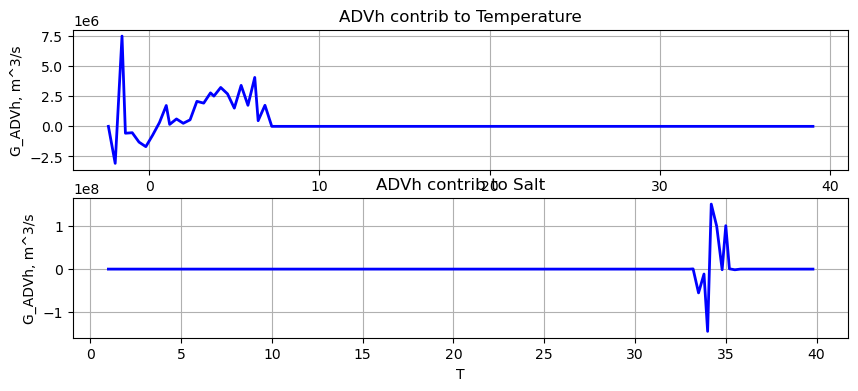

In [85]:
# plot this with T, does this look correct?
fig = plt.figure()

# make sure this is just the Barents Sea -- not verified that that is true

ax = plt.subplot(211)

ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],linewidth=2,c="blue",label="offline") # advh
ax.set_ylabel("G_ADVh, m^3/s")
ax.set_xlabel("T")
ax.grid()
plt.title("ADVh contrib to Temperature")

ax = plt.subplot(212)

ax.plot(boundsS.flatten()[1:-1],G_S_offline_new[0],linewidth=2,c="blue",label="offline") # advh
ax.set_ylabel("G_ADVh, m^3/s")
ax.set_xlabel("T")
ax.grid()
plt.title("ADVh contrib to Salt")

### create the gateway term in T

In [86]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

In [87]:
t2 = int(tsstr[0])

In [99]:
# LOAD ADV FOR BOTH T AND S
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","ADVx_SLT","ADVy_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[3])

In [100]:
# we need to also create the theta and salt bins for this area
t2 = int(tsstr[0])
# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(layers_path + "diags/STATE/" + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(layers_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(layers_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [101]:
# define the following as a function to use for any ADV and tracer value

def gate_transport(ADVx_TH,ADVy_TH,THETA):
    # get the gateway transports for the Barents Sea from ADVx and y of TH or SALT, with the tracer T or S
    
    # --- reshape to 3D ---
    ADVx_TH = ADVx_TH.reshape((nz, ny, nx))   # advective heat flux on x-faces
    ADVy_TH = ADVy_TH.reshape((nz, ny, nx))   # advective heat flux on y-faces
    THETA   = THETA.reshape((nz, ny, nx))     # cell-centered temperature
    
    # ------------------------------------------------------------------
    # 1. Build theta at faces
    # ------------------------------------------------------------------
    
    # x-faces: between (i-1, i) along x
    theta_x = np.zeros_like(ADVx_TH)
    theta_x[:, :, 1:] = 0.5 * (THETA[:, :, 1:] + THETA[:, :, :-1])
    theta_x[:, :, 0]  = theta_x[:, :, 1]      # simple fill for western boundary
    
    # y-faces: between (j-1, j) along y
    theta_y = np.zeros_like(ADVy_TH)
    theta_y[:, 1:, :] = 0.5 * (THETA[:, 1:, :] + THETA[:, :-1, :])
    theta_y[:, 0, :]  = theta_y[:, 1, :]      # simple fill for southern boundary
    
    # ------------------------------------------------------------------
    # 2. Convert heat flux (degC·m^3/s) -> volume flux (m^3/s)
    #    q_vol = q_heat / theta_face
    # ------------------------------------------------------------------
    
    eps = 1e-6  # to avoid divide-by-zero in very cold cells
    
    ADVx_vol = np.zeros_like(ADVx_TH)
    mask_x   = np.isfinite(theta_x) & (np.abs(theta_x) > eps)
    ADVx_vol[mask_x] = ADVx_TH[mask_x] #/ theta_x[mask_x]
    
    ADVy_vol = np.zeros_like(ADVy_TH)
    mask_y   = np.isfinite(theta_y) & (np.abs(theta_y) > eps)
    ADVy_vol[mask_y] = ADVy_TH[mask_y] #/ theta_y[mask_y]
    
    # bolus
    ADVx_vol = np.zeros_like(ADVx_TH)
    mask_x   = np.isfinite(theta_x) & (np.abs(theta_x) > eps)
    ADVx_vol[mask_x] = (ADVx_TH[mask_x]) #/ theta_x[mask_x]
    
    ADVy_vol = np.zeros_like(ADVy_TH)
    mask_y   = np.isfinite(theta_y) & (np.abs(theta_y) > eps)
    ADVy_vol[mask_y] = (ADVy_TH[mask_y]) #/ theta_y[mask_y]
    
    # ------------------------------------------------------------------
    # 3. Build gateway transports using volume fluxes at the faces
    #    Sign convention: comments assume "positive into basin"
    # ------------------------------------------------------------------
    
    # ADVx_vol = ADVx_TH
    # ADVy_vol = ADVy_TH
    
    # ---- BSO ----
    ADV_west = np.zeros((nz, ny, nx))
    y_bso_all = np.array([], dtype=int)
    x_bso_all = np.array([], dtype=int)
    
    # horizontal faces (u-faces)
    for j, i in zip(y_bsoh, x_bsoh):
        # flux through x-face at (j,i) mapped into cell (j,i)
        ADV_west[:, j, i] += ADVx_vol[:, j, i]    # + into basin
        y_bso_all = np.append(y_bso_all, j)
        x_bso_all = np.append(x_bso_all, i)
    
    # vertical faces (v-faces)
    for j, i in zip(y_bsov, x_bsov):
        # flux through y-face at (j,i) mapped into cell (j-1,i)
        ADV_west[:, j-1, i] -= ADVy_vol[:, j, i]  # sign chosen so + into basin
        y_bso_all = np.append(y_bso_all, j-1)
        x_bso_all = np.append(x_bso_all, i)
    
    # ---- FJNZ ----
    ADV_FJNZ = np.zeros((nz, ny, nx))
    y_fjnz_all = np.array([], dtype=int)
    x_fjnz_all = np.array([], dtype=int)
    
    for j, i in zip(y_fjnzv, x_fjnzv):
        # x-face at (j,i) mapped into (j, i-1), + into basin
        ADV_FJNZ[:, j, i-1] -= ADVx_vol[:, j, i]
        y_fjnz_all = np.append(y_fjnz_all, j)
        x_fjnz_all = np.append(x_fjnz_all, i-1)
    
    # ---- SPFJ (NZ exit) ----
    ADV_SPFJ = np.zeros((nz, ny, nx))
    y_spfj_all = np.array([], dtype=int)
    x_spfj_all = np.array([], dtype=int)
    
    # # CHANGED
    for j,i in zip(y_spfjv,x_spfjv):
        ADV_SPFJ[:, j-1, i] -= ADVy_vol[:, j, i]
        y_spfj_all = np.append(y_spfj_all, j-1)
        x_spfj_all = np.append(x_spfj_all, i)
    
    for j,i in zip(y_spfjh,x_spfjh):
        ADV_SPFJ[:, j, i-1] -= ADVx_vol[:, j, i]
        y_spfj_all = np.append(y_spfj_all, j)
        x_spfj_all = np.append(x_spfj_all, i-1)
        
    for j,i in zip(y_spfjb,x_spfjb):
        ADV_SPFJ[:, j, i-1] -= ADVx_vol[:, j, i]
        y_spfj_all = np.append(y_spfj_all, j)
        x_spfj_all = np.append(x_spfj_all, i-1)
        ADV_SPFJ[:, j-1, i] -= ADVy_vol[:, j, i]
        y_spfj_all = np.append(y_spfj_all, j-1)
        x_spfj_all = np.append(x_spfj_all, i)
    
    # ---- NZRU (small Russia gate) ----
    ADV_NZRU = np.zeros((nz, ny, nx))
    y_nzru_all = np.array([], dtype=int)
    x_nzru_all = np.array([], dtype=int)
    
    for j, i in zip(y_nzruv, x_nzruv):
        ADV_NZRU[:, j, i-1] -= ADVx_vol[:, j, i]   # + into basin
        y_nzru_all = np.append(y_nzru_all, j)
        x_nzru_all = np.append(x_nzru_all, i-1)

    return ADV_west,ADV_FJNZ,ADV_SPFJ,ADV_NZRU  # in m^3.tracer/s

In [103]:
ADV_westT,ADV_FJNZT,ADV_SPFJT,ADV_NZRUT = gate_transport(ADVx_TH,ADVy_TH,THETA)
ADV_westS,ADV_FJNZS,ADV_SPFJS,ADV_NZRUS = gate_transport(ADVx_SLT,ADVy_SLT,SALT)

In [105]:
# define a function to turn the gates as 3D into 1D for T and S
def gateway3D(ADV_west,ADV_FJNZ,ADV_SPFJ,ADV_NZRU,tracer,binmidTracer,nTm1):
    tracer_flat = tracer.ravel()
    bin_idx_mid = np.digitize(tracer_flat, binmidTracer, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(tracer_flat)
    idx_mid     = bin_idx_mid[valid_mid]

    # flatten these so we can bin
    ADV_west_flat   = ADV_west.ravel()
    ADV_fjnz_flat   = ADV_FJNZ.ravel()
    ADV_spfj_flat   = ADV_SPFJ.ravel()
    ADV_nzru_flat   = ADV_NZRU.ravel()

    # per-bin sums with NaN-propagation
    ADVh_BSO = _bincount_sum_with_nan(idx_mid, ADV_west_flat[valid_mid], nTm1)
    ADVh_FJNZ = _bincount_sum_with_nan(idx_mid, ADV_fjnz_flat[valid_mid], nTm1)
    ADVh_SPFJ = _bincount_sum_with_nan(idx_mid, ADV_spfj_flat[valid_mid], nTm1)
    ADVh_NZRU = _bincount_sum_with_nan(idx_mid, ADV_nzru_flat[valid_mid], nTm1)
    
    # edge-based G (m^3/s): divide by edge binwidths
    # this is not correct because we want to divide by Face T
    G_BSO = ADVh_BSO #/ binwidthT1
    G_FJNZ = ADVh_FJNZ #/ binwidthT1
    G_SPFJ = ADVh_SPFJ #/ binwidthT1
    G_NZRU = ADVh_NZRU #/ binwidthT1

    return G_BSO,G_FJNZ,G_SPFJ,G_NZRU

In [106]:
theta_flat = THETA.ravel()
salt_flat = SALT.ravel()

G_BSOT,G_FJNZT,G_SPFJT,G_NZRUT = gateway3D(ADV_westT,ADV_FJNZT,ADV_SPFJT,ADV_NZRUT,THETA,binmidT,nTm1)
G_BSOS,G_FJNZS,G_SPFJS,G_NZRUS = gateway3D(ADV_westS,ADV_FJNZS,ADV_SPFJS,ADV_NZRUS,SALT,binmidS,nSm1)

In [116]:
MsumS = G_BSOS + G_FJNZS + G_SPFJS+ G_NZRUS
MsumT = G_BSOT + G_FJNZT + G_SPFJT + G_NZRUT

MsumS[np.isnan(MsumS)] = 0
MsumT[np.isnan(MsumT)] = 0

Text(0.5, 1.0, 'ADVh contrib to Salt')

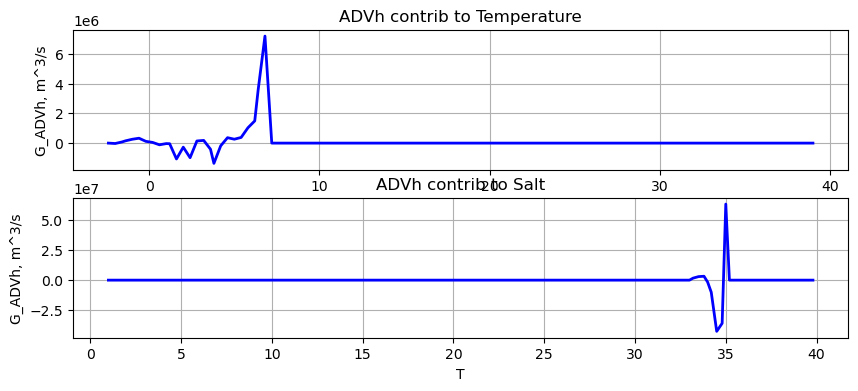

In [117]:
# plot this with T, does this look correct?
fig = plt.figure()

# make sure this is just the Barents Sea -- not verified that that is true

ax = plt.subplot(211)

ax.plot(boundsT.flatten()[1:-1],MsumT,linewidth=2,c="blue",label="offline") # advh
ax.set_ylabel("G_ADVh, m^3/s")
ax.set_xlabel("T")
ax.grid()
plt.title("ADVh contrib to Temperature")

ax = plt.subplot(212)

ax.plot(boundsS.flatten()[1:-1],MsumS,linewidth=2,c="blue",label="offline") # advh
ax.set_ylabel("G_ADVh, m^3/s")
ax.set_xlabel("T")
ax.grid()
plt.title("ADVh contrib to Salt")

In [118]:
print(np.nansum(ADV_Tnew[0]) / np.nansum(binwidthT1))
print(np.nansum((G_BSOT + G_FJNZT + G_SPFJT+ G_NZRUT)) / np.nansum(binwidthT1))  # in m^3/s

255914.69161857062
265105.6637515711


In [119]:
print(np.nansum(ADV_Snew[0]) / np.nansum(binwidthS1))
print(np.nansum((G_BSOS + G_FJNZS + G_SPFJS+ G_NZRUS)) / np.nansum(binwidthS1))  # in m^3/s

983265.393916637
-485413.7695640889


In [ ]:
# do the same thing for salt

## show budget closure here using the tendency term and the G terms calculated from the file

In [120]:
# let's first show with the internal advection, if possible